In [153]:
import tensorflow as tf

In [146]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import numpy as np

In [2]:
import pandas as pd 
df = pd.read_csv('athlete_events.csv')
df.head()

ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's Football   NaN  
3       Tug-Of-War Men's Tug-Of-War  Gold  
4  Speed Skating Women's 500 metres   NaN

In [87]:
df_2020 = pd.read_csv('Tokyo 2021 dataset v4.csv').rename({'NOCCode': 'NOC'}, axis=1)
df_2020.head()

Rank                    Team/NOC  Gold Medal  Silver Medal  Bronze Medal  \
0     1    United States of America          39            41            33   
1     2  People's Republic of China          38            32            18   
2     3                       Japan          27            14            17   
3     4               Great Britain          22            21            22   
4     5                         ROC          20            28            23   

   Total  Rank by Total  NOC      Continent  
0    113              1  USA  North America  
1     88              2  CHN           Asia  
2     58              5  JPN           Asia  
3     65              4  GBR         Europe  
4     71              3  ROC    Europe/Asia

In [6]:
df_filtered = df[(df["Medal"].notna()) & (df["Season"]=='Summer')]
df_filtered.head()

ID                     Name Sex   Age  Height  Weight            Team  \
3    4     Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
37  15     Arvo Ossian Aaltonen   M  30.0     NaN     NaN         Finland   
38  15     Arvo Ossian Aaltonen   M  30.0     NaN     NaN         Finland   
41  17  Paavo Johannes Aaltonen   M  28.0   175.0    64.0         Finland   
42  17  Paavo Johannes Aaltonen   M  28.0   175.0    64.0         Finland   

    NOC        Games  Year  Season       City       Sport  \
3   DEN  1900 Summer  1900  Summer      Paris  Tug-Of-War   
37  FIN  1920 Summer  1920  Summer  Antwerpen    Swimming   
38  FIN  1920 Summer  1920  Summer  Antwerpen    Swimming   
41  FIN  1948 Summer  1948  Summer     London  Gymnastics   
42  FIN  1948 Summer  1948  Summer     London  Gymnastics   

                                     Event   Medal  
3              Tug-Of-War Men's Tug-Of-War    Gold  
37  Swimming Men's 200 metres Breaststroke  Bronze  
38  Swimming Men's 400 metres Breaststroke  Bronze  
41  Gymnastics Men's Individual All-Around  Bronze  
42        Gymnastics Men's Team All-Around    Gold

In [89]:
df_grouped = df_filtered.groupby(["NOC", "Year", "Medal"])["Event"].nunique().reset_index(name="medal_counts")
df_grouped.sort_values(by=["medal_counts"], ascending=False).head()

NOC  Year   Medal  medal_counts
2711  USA  1984    Gold            82
2639  URS  1980    Gold            80
2661  USA  1904  Silver            79
2660  USA  1904    Gold            76
2659  USA  1904  Bronze            75

In [86]:
noc = 'USA'
medal = 'Gold'
df_sequence = df_grouped[(df_grouped["NOC"] == noc) & (df_grouped["Medal"] == medal)].sort_values(by=["Year"], ascending=False)
print(df_sequence.shape)
df_sequence.head()

(28, 4)


NOC  Year Medal  medal_counts
2735  USA  2016  Gold            46
2732  USA  2012  Gold            46
2729  USA  2008  Gold            36
2726  USA  2004  Gold            36
2723  USA  2000  Gold            36

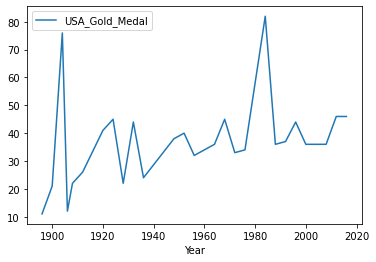

In [96]:
df_sequence.rename({'medal_counts': noc+'_'+medal+'_Medal'}, axis=1).plot(x="Year", y=noc+'_'+medal+'_Medal')

In [44]:
def sampling(sequence, n_steps):
  X, Y = list(), list()
  for i in range(len(sequence)):
    sam = i + n_steps
    if sam > len(sequence)-1:
      break
    x, y = sequence[i:sam], sequence[sam]
    X.append(x)
    Y.append(y)
  return np.array(X), np.array(Y)

In [74]:
n_steps = 7
X, Y = sampling(df_sequence.sort_values(by=["Year"], ascending=True)["medal_counts"].tolist(), n_steps)

In [76]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [77]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.fit(X, Y, epochs=200, verbose=0)

In [154]:
x = np.array(df_sequence.sort_values(by=["Year"], ascending=True)["medal_counts"].tolist()[-n_steps:])
x = x.reshape((1, n_steps, 1))

In [81]:
ypred = model.predict(x, verbose=0)
ypred

array([[39.13635]], dtype=float32)

In [102]:
def medal_pred(df_grouped, noc, medal, n_steps):
  df_sequence = df_grouped[(df_grouped["NOC"] == noc) & (df_grouped["Medal"] == medal)].sort_values(by=["Year"], ascending=False)
  df_sequence.rename({'medal_counts': noc+'_'+medal+'_Medal'}, axis=1).plot(x="Year", y=noc+'_'+medal+'_Medal')
  X, Y = sampling(df_sequence.sort_values(by=["Year"], ascending=True)["medal_counts"].tolist(), n_steps)
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  X = X.reshape((X.shape[0], X.shape[1], 1))
  model.fit(X, Y, epochs=200, verbose=0)
  x = np.array(df_sequence.sort_values(by=["Year"], ascending=True)["medal_counts"].tolist()[-n_steps:])
  x = x.reshape((1, n_steps, 1))
  ypred = model.predict(x, verbose=0)
  return ypred[0][0]

34.954918

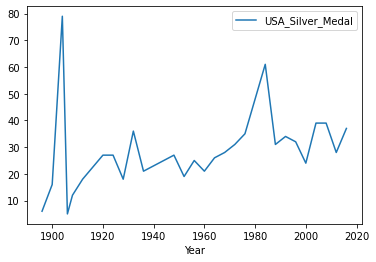

In [106]:
medal_pred(df_grouped, 'USA', 'Silver', 7)

30.106728

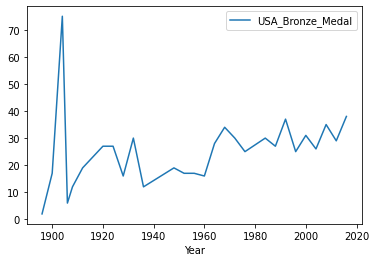

In [110]:
medal_pred(df_grouped, 'USA', 'Bronze', 7)

In [115]:
df_grouped_total = df_grouped.groupby(["NOC", "Year"]).sum("medal_counts").reset_index()
df_grouped_total.sort_values(by=["medal_counts"], ascending=False).head()

NOC  Year  medal_counts
1210  USA  1904           230
1198  URS  1980           195
1227  USA  1984           173
428   GBR  1908           143
1199  URS  1988           131

In [116]:
def total_medal_pred(df_grouped, noc, n_steps):
  df_sequence = df_grouped[(df_grouped["NOC"] == noc)].sort_values(by=["Year"], ascending=False)
  df_sequence.rename({'medal_counts': noc+'_Total_Medal'}, axis=1).plot(x="Year", y=noc+'_Total_Medal')
  X, Y = sampling(df_sequence.sort_values(by=["Year"], ascending=True)["medal_counts"].tolist(), n_steps)
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  X = X.reshape((X.shape[0], X.shape[1], 1))
  model.fit(X, Y, epochs=200, verbose=0)
  x = np.array(df_sequence.sort_values(by=["Year"], ascending=True)["medal_counts"].tolist()[-n_steps:])
  x = x.reshape((1, n_steps, 1))
  ypred = model.predict(x, verbose=0)
  return round(ypred[0][0])

20

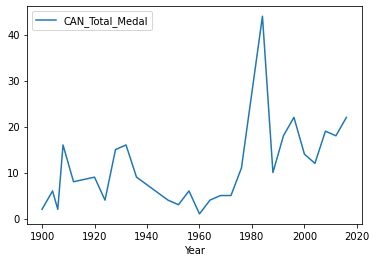

In [123]:
total_medal_pred(df_grouped_total, 'CAN', 7)

67

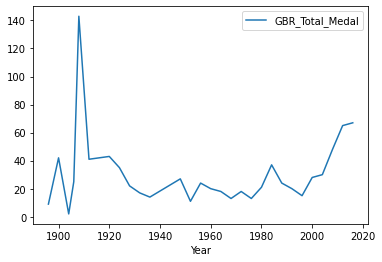

In [125]:
total_medal_pred(df_grouped_total, 'GBR', 7)

35

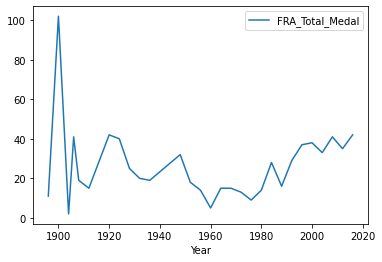

In [126]:
total_medal_pred(df_grouped_total, 'FRA', 7)

43

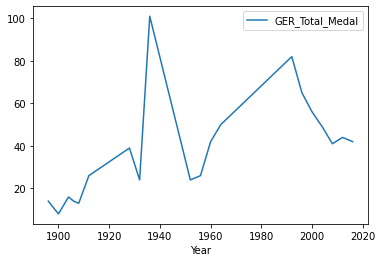

In [131]:
total_medal_pred(df_grouped_total, 'GER', 7)

28

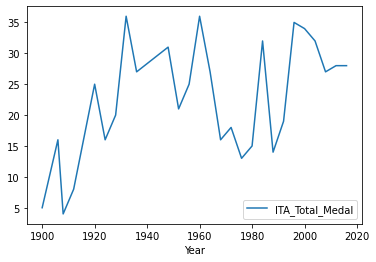

In [141]:
total_medal_pred(df_grouped_total, 'ITA', 7)

53

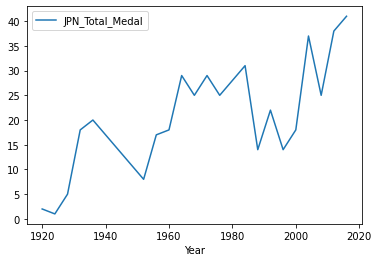

In [142]:
total_medal_pred(df_grouped_total, 'JPN', 7)